# 12wk-2: 순환신경망 (3) – `RNN`, `LSTM`

최규빈  
2024-05-21

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/12wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xq0bBQn8ZP607mS0ZKI8Sg&si=-cQULuc2x7noftgE>

# 2. Import

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
soft = torch.nn.Softmax(dim=1)

# 3. `AbAcAd` – `RNN` + GPU

## A. Data

`-` 데이터 정리

In [142]:
txt = list('AbAcAd'*50)
txt[:10]

In [143]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

## B. 구현1 – RNNCell (지난시간)

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

`-` 데이터정리

In [83]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

`-` Net설계 및 가중치 설정 (구현1과 동일하도록 가중치 초기화)

In [84]:
torch.manual_seed(4) 
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

`-` 손실함수 및 옵티마이저 설정

In [57]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()),lr=0.1)

In [58]:
L = len(X)
for epoc in range(200):
    ## 1~2 
    ht = torch.zeros(2) # 첫간장은 맹물
    loss = 0
    for t in range(L):
        Xt, yt = X[t], y[t]
        ht = rnncell(Xt, ht)
        ot = cook(ht) 
        loss = loss + loss_fn(ot, yt)
    loss = loss/L
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [59]:
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
    h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))
yhat

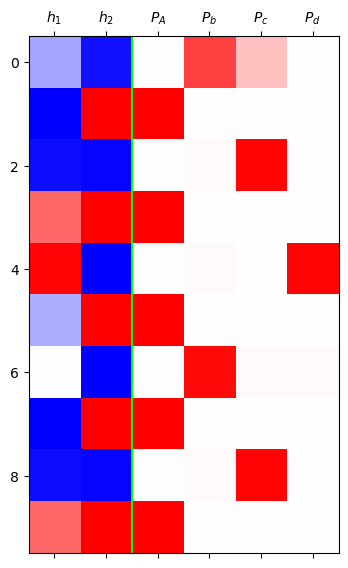

In [60]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

## C. 구현2 – RNN

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNN.html>

In [61]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [62]:
torch.manual_seed(4) 
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

In [63]:
rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

In [64]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [65]:
Water = torch.zeros(1,2)
for epoc in range(200):
    ## 1
    h,hL = rnn(X,Water)
    netout = cook(h)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [66]:
h,hL = rnn(X,Water)
netout = cook(h)
yhat = soft(netout)
yhat

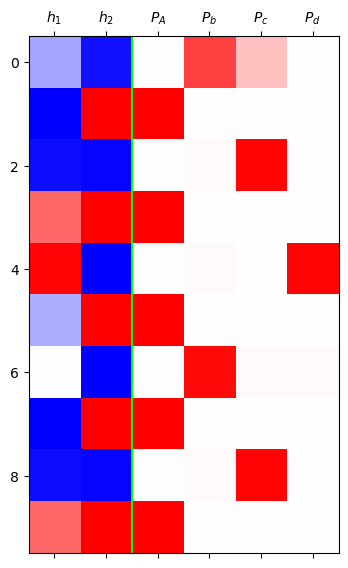

In [67]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

## D. 구현3 – RNN + GPU

In [68]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [69]:
torch.manual_seed(4) 
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

In [70]:
rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

In [71]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [72]:
X = X.to("cuda:0")
y = y.to("cuda:0")
rnn.to("cuda:0") 
cook.to("cuda:0")
Water = torch.zeros(1,2).to("cuda:0")
for epoc in range(200):
    ## 1
    h,hL = rnn(X,Water)
    netout = cook(h)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [73]:
h,hL = rnn(X,Water)
netout = cook(h)
yhat = soft(netout)
yhat

-   살짝결과다름

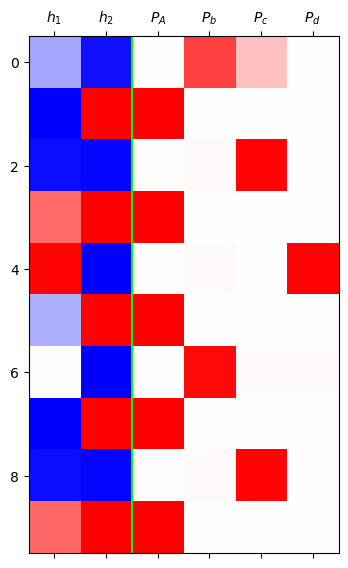

In [74]:
mat = torch.concat([h,yhat],axis=1).data[:10].to("cpu")
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

## E. 구현3 – RNN + GPU + 맹물생략

In [99]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [100]:
torch.manual_seed(4) 
rnncell = torch.nn.RNNCell(4,2)
cook = torch.nn.Linear(2,4)

In [101]:
rnn = torch.nn.RNN(4,2)
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data
rnn.weight_hh_l0.data = rnncell.weight_hh.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data

In [102]:
loss_fn = torch.nn.CrossEntropyLoss() 
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()),lr=0.1)

In [103]:
X = X.to("cuda:0")
y = y.to("cuda:0")
rnn.to("cuda:0") 
cook.to("cuda:0")
Water = torch.zeros(1,2).to("cuda:0")
for epoc in range(200):
    ## 1
    h,_ = rnn(X)
    netout = cook(h)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [104]:
h,_ = rnn(X)
netout = cook(h)
yhat = soft(netout)
yhat

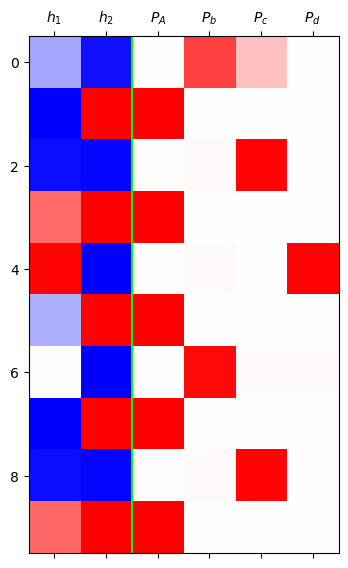

In [106]:
mat = torch.concat([h,yhat],axis=1).data[:10].to("cpu")
plt.matshow(mat,cmap='bwr',vmin=-1,vmax=1)
plt.axvline(x=1.5,color='lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

## F. 은닉노드 비교실험

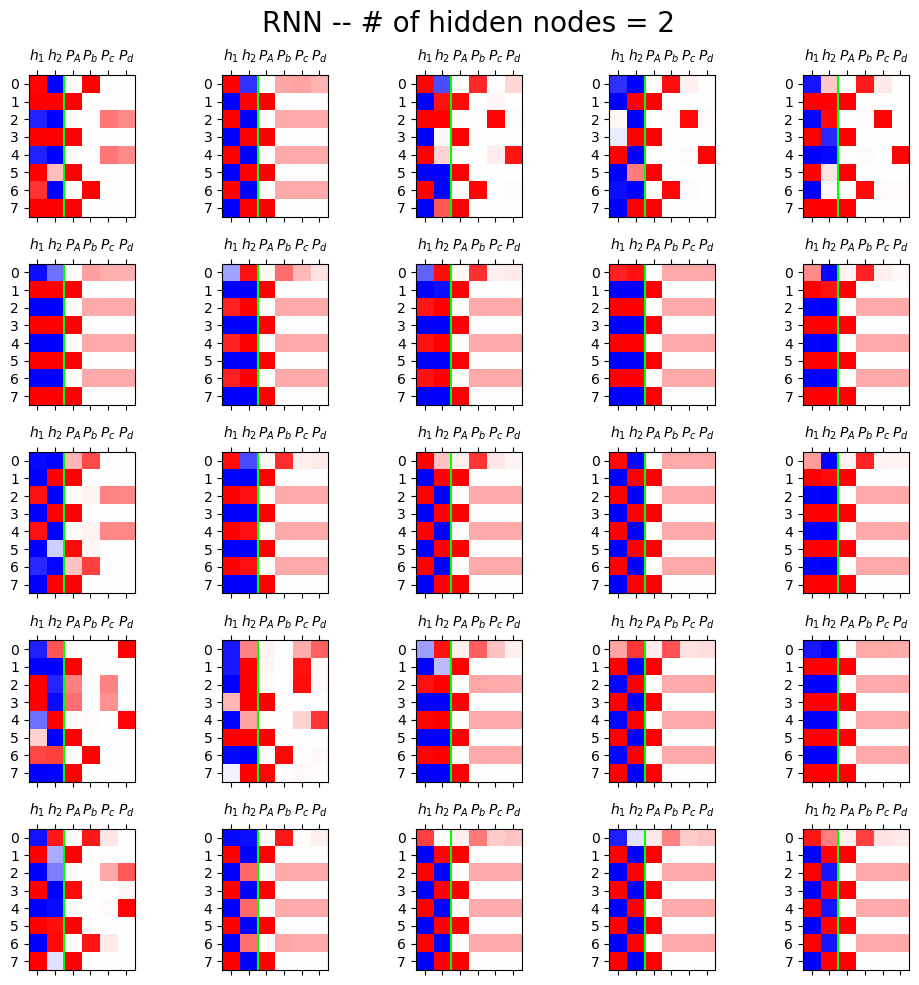

In [146]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,2).to("cuda:0")
        cook = torch.nn.Linear(2,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=1.5,color="lime")
        ax[i][j].set_xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 2",size=20)
fig.tight_layout()

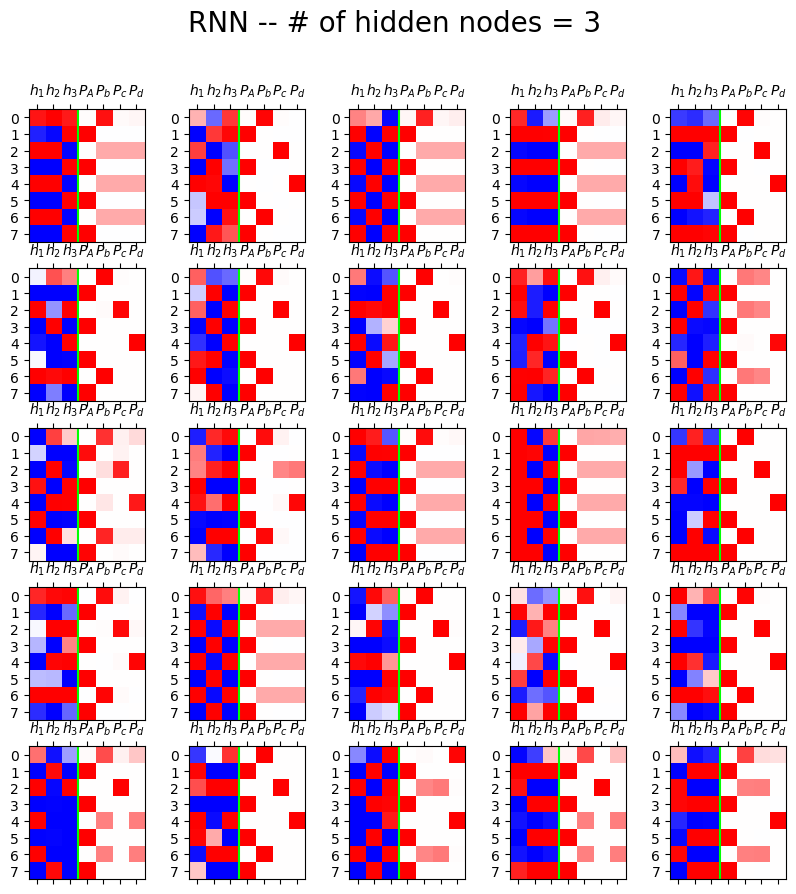

In [147]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,3).to("cuda:0")
        cook = torch.nn.Linear(3,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=2.5,color="lime")
        ax[i][j].set_xticks(range(7),[r'$h_1$',r'$h_2$',r'$h_3$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 3",size=20)
fig.tight_laytight_layout

In [ ]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,4).to("cuda:0")
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(200):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("RNN -- # of hidden nodes = 4",size=20)
fig.tight_layout()

# 4. `abcabC`

## A. Data

`-` 데이터 정리

In [149]:
txt = list('abcabC'*50)
txt[:10]

In [150]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

## B. RNN

ref: <https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html>

In [ ]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        rnn = torch.nn.RNN(4,4).to("cuda:0")
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(rnn.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(500):
            ## 1
            h,_ = rnn(X)
            netout = cook(h)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = rnn(X)[0].data.to("cpu")
        yhat = soft(cook(rnn(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr")
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_C$'])
fig.suptitle("RNN -- # of hidden nodes = 4",size=20)
fig.tight_layout()

## C. LSTM

In [ ]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2,'C':3}))
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2,'C':3}))
X = torch.nn.functional.one_hot(x).float().to("cuda:0")
y = torch.nn.functional.one_hot(y).float().to("cuda:0")
fig,ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        lstm = torch.nn.LSTM(4,4).to("cuda:0")
        cook = torch.nn.Linear(4,4).to("cuda:0")
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizr = torch.optim.Adam(list(lstm.parameters()) + list(cook.parameters()), lr=0.1)
        for epoc in range(500):
            ## 1
            h,_ = lstm(X)
            netout = cook(h)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = lstm(X)[0].data.to("cpu")
        yhat = soft(cook(lstm(X)[0])).data.to("cpu")
        mat = torch.concat([h,yhat],axis=1)[:8]
        ax[i][j].matshow(mat,cmap="bwr",vmin=-1,vmax=1)
        ax[i][j].axvline(x=3.5,color="lime")
        ax[i][j].set_xticks(range(8),[r'$h_1$',r'$h_2$',r'$h_3$',r'$h_4$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_C$'])
fig.suptitle("LSTM -- # of hidden nodes = 4",size=20)
fig.tight_layout()